In [2]:
from __future__ import print_function
import copy
# import cProfile, pstats, StringIO
import iminuit
# %load_ext ipycache
%load_ext line_profiler
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from multiprocessing import Pool
import numba
import numpy as np
import os
import pandas as pd
import pymp
import random
import scipy as sp
from scipy import optimize
from scipy import stats
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [3]:
import atm_c14_data
import c14_models
import c14_individuals_data

# reload(atm_c14_data)
# reload(c14_models)
# reload(c14_individuals_data);

/Users/fabrost/work/C14_liver/atm_c14_data.py:32: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  last_c14 = c14_data['d14C'].loc[c14_data['year'].argmax()]


In [4]:
def CI(M, p):
    value = M.values[p]
    lower = M.get_merrors()[p]['lower']
    upper = M.get_merrors()[p]['upper']
    return value + lower, value + upper

In [5]:
Klag = atm_c14_data.Klag
K = atm_c14_data.K
C = c14_models.C_scenario_A
C2 = c14_models.C_scenario_2POP

In [6]:
c14_patient_data = c14_individuals_data.c14_individual_data

In [7]:
hepatocyte_data = c14_individuals_data.c14_individual_data.query('type == "hepatocyte"')
hepatocyte_data.describe()

,Dbirth,Dcoll,d14C,mass
count,19.000000,19.000000,19.000000,19.0
mean,1964.021930,2015.605263,0.043114,1.0
std,20.059938,3.810909,0.021048,0.0
min,1932.583333,2004.833333,0.017700,1.0
25%,1946.166667,2016.458333,0.027331,1.0
50%,1964.000000,2016.750000,0.039600,1.0
75%,1981.250000,2017.125000,0.051000,1.0
max,1995.333333,2017.416667,0.090351,1.0


## Scenario L

### The model

In [8]:
@numba.njit
def C_atm(x):
    x -=1
    xp = np.array([ 1891.5, 1892.5, 1893.5, 1894.5, 1895.5, 1896.5, 1897.5, 1898.5, 1899.5, 1900.5, 1901.5, 1902.5, 1903.5, 1904.5, 1905.5, 1906.5, 1907.5, 1908.5, 1909.5, 1910.5, 1911.5, 1912.5, 1913.5, 1914.5, 1915.5, 1916.5, 1917.5, 1918.5, 1919.5, 1920.5, 1921.5, 1922.5, 1923.5, 1924.5, 1925.5, 1926.5, 1927.5, 1928.5, 1929.5, 1930.5, 1931.5, 1932.5, 1933.5, 1934.5, 1935.5, 1936.5, 1937.5, 1938.5, 1939.5, 1940.5, 1941.5, 1942.5, 1943.5, 1944.5, 1945.5, 1946.5, 1947.5, 1948.5, 1949.5, 1950.5, 1951.5, 1952.5, 1953.5, 1954.5, 1955.5, 1956.5, 1957.5, 1958.5, 1959.5, 1960.5, 1961.5, 1962.5, 1963.5, 1964.5, 1965.5, 1966.5, 1967.5, 1968.5, 1969.5, 1970.5, 1971.5, 1972.5, 1973.5, 1974.5, 1975.5, 1976.5, 1977.5, 1978.5, 1979.5, 1980.5, 1981.5, 1982.5, 1983.5, 1984.5, 1985.5, 1986.5, 1987.5, 1988.5, 1989.5, 1990.5, 1991.5, 1992.5, 1993.5, 1994.5, 1995.5, 1996.5, 1997.5, 1998.5, 1999.5, 2000.5, 2001.5, 2002.5, 2003.5, 2003.963938,  2004.421821,  2004.879704, 2005.337587,  2005.79547 ,  2006.253353,  2006.711236, 2007.169119,  2007.627002,  2008.084885,  2008.542768, 2009.000651,  2009.458534,  2009.916417,  2010.3743  , 2010.3743  ,  2010.626   ,  2011.125   ,  2011.626   , 2012.125   ,  2012.626   ,  2013.125   ,  2013.626   , 2014.125   ,  2014.626   ,  2015.125   ,  2015.625   , 2016.125   ,  2016.625   ,  2020.      ])
    fp = np.array([-0.002     , -0.002     , -0.002     , -0.002     , -0.002     , -0.00233   , -0.00267   , -0.003     , -0.00333   , -0.00367   , -0.004     , -0.00433   , -0.00467   , -0.005     , -0.00533   , -0.00567   , -0.006     , -0.00633   , -0.00667   , -0.007     , -0.00733   , -0.00767   , -0.008     , -0.00833   , -0.00867   , -0.009     , -0.00933   , -0.00967   , -0.01      , -0.01033   , -0.01067   , -0.011     , -0.01133   , -0.01167   , -0.012     , -0.01233   , -0.01267   , -0.013     , -0.01333   , -0.01367   , -0.014     , -0.01433   , -0.01467   , -0.015     , -0.01533   , -0.01567   , -0.016     , -0.01633   , -0.01667   , -0.0202    , -0.0194    , -0.0196    , -0.0225    , -0.0217    , -0.0221    , -0.0216    , -0.0211    , -0.0223    , -0.0246    , -0.0248    , -0.0248    , -0.0249    , -0.0239    , -0.0211    , -0.0082    , 0.0265    ,  0.073     ,  0.1402    ,  0.228     ,  0.2123    , 0.2216    ,  0.3585    ,  0.7183    ,  0.8357    ,  0.7563    , 0.6919    ,  0.6236    ,  0.5645    ,  0.5454    ,  0.5291    , 0.4994    ,  0.4656    ,  0.4186    ,  0.4008    ,  0.3698    , 0.3525    ,  0.3339    ,  0.3258    ,  0.2958    ,  0.2645    , 0.2567    ,  0.2383    ,  0.2242    ,  0.2093    ,  0.2013    , 0.1911    ,  0.1826    ,  0.1734    ,  0.1635    ,  0.1525    , 0.1429    ,  0.1364    ,  0.1284    ,  0.1221    ,  0.1155    , 0.1099    ,  0.1043    ,  0.0981    ,  0.09      ,  0.0866    , 0.0807    ,  0.0749    ,  0.0689    ,  0.06349874,  0.06145905, 0.0597412 ,  0.05822747,  0.05641489,  0.05479531,  0.05364811, 0.05205465,  0.05067073,  0.04927897,  0.04788014,  0.04647508, 0.04506462,  0.04364948,  0.04223027,  0.04223027,  0.0403    , 0.0347    ,  0.0371    ,  0.0312    ,  0.0299    ,  0.0193    , 0.0219    ,  0.0182    ,  0.018     ,  0.0116    ,  0.0129    , 0.0096    ,  0.0097    ,  0.0097    ])
    
    if x<xp[0]:
        return fp[0]
    elif x>xp[-1]:
        return fp[-1]
    else:
        for i in range(len(xp)):
            if x<xp[i]:
                break
        return fp[i-1] + (fp[i] - fp[i-1]) * (x - xp[i-1]) / (xp[i] - xp[i-1])

In [9]:
def C_L1c(Dbirth, Dcoll, r):
    def rhs(c, t, r):
        return 0.5 * r * (C_atm(t) - c)
    def Dfun(c, t0, r):
        return -0.5 * r
    C = sp.integrate.odeint(rhs, C_atm(Dbirth), np.linspace(Dbirth, Dcoll), args = (r, ), Dfun = Dfun)[-1, 0]
    return C

### constant sigma

In [10]:
sigma_estimate = hepatocyte_data['d14C'].std()
sigma_estimate

0.02104804968727416

In [11]:
def neg_loglike_L1(logr, sigma):
    r = np.exp(logr)
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C_L1c(Dbirth, Dcoll, r)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
#     print(logr, r, sigma, loglike)
    return -loglike

In [12]:
M_L1 = iminuit.Minuit(neg_loglike_L1, errordef = 0.5,\
           logr = -0.8, error_logr = 0.1, limit_logr = (-1e2, 1e2), fix_logr = False,\
           sigma = 0.0163, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
           print_level = 1)
M_L1.migrad();

FCN = -50.676878261671675 
 TOTAL NCALL = 52 
 NCALLS = 52 
 
 
 EDM = 4.430135088457656e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,logr,-0.915684,0.0183702,0,0,-100.0,100.0,
2,sigma,0.0168115,0.00272844,0,0,0.0,,


In [13]:
C = C_L1c

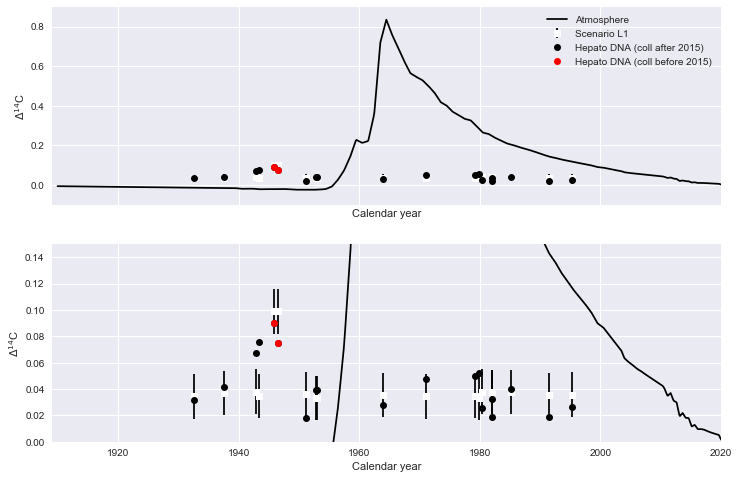

In [14]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (12, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, K(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(hepatocyte_data['Dbirth'], \
               sp.vectorize(C)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], np.exp(M_L1.values['logr'])), 
                M_L1.values['sigma'],
               color = 'white', ecolor = 'black', label = 'Scenario L1', marker='s', ls = '')


    ax.errorbar(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], 
            marker = 'o', ls = 'None', color = 'black',
               label = 'Hepato DNA (coll after 2015)')
    ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
               marker = 'o', ls = 'None', color = 'red', 
               label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)
    
plt.savefig('plots/c14_predict_L1.png', bbox_inches='tight', dpi=300)

plt.show()

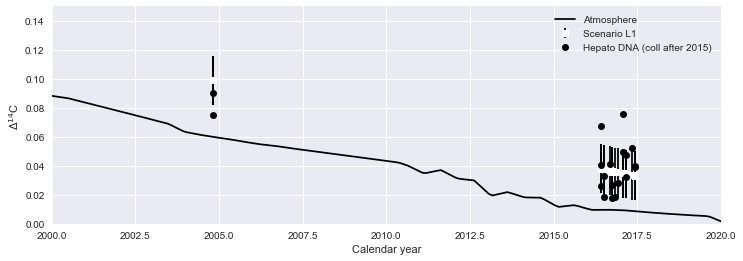

In [15]:
fig, ax = plt.subplots(figsize = (12, 4))

time = sp.linspace(1910.0, 2020.0, 1000)


ax.plot(time, K(time), label = 'Atmosphere', color = 'black')

ax.errorbar(hepatocyte_data['Dcoll'], \
           sp.vectorize(C)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], np.exp(M_L1.values['logr'])), 
            M_L1.values['sigma'],
           color = 'white', ecolor = 'black', label = 'Scenario L1', marker='s', ls = '')


ax.errorbar(hepatocyte_data['Dcoll'], hepatocyte_data['d14C'], 
        marker = 'o', ls = 'None', color = 'black',
           label = 'Hepato DNA (coll after 2015)')
#    ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dcoll'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
#               marker = 'o', ls = 'None', color = 'red', 
#               label = 'Hepato DNA (coll before 2015)')


ax.set_xlim((2000, 2020))
ax.set_ylim(-0.1, 0.9)
#ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')


ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

ax.legend()
ax.set_ylim(-0.0, 0.15)
    
plt.savefig('plots/c14_predict_L1_coll.png', bbox_inches='tight', dpi=300)

plt.show()

In [16]:
M_L1.minos(sigma=1.0)

Error,-0.1294186393461066,0.15457636786346382
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


/anaconda3/envs/py3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Error,-0.002728438277202816,0.003135971334455159
Valid,False,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'logr': {'lower': -0.1294186393461066, 'upper': 0.15457636786346382, 'is_valid': True, 'lower_valid': True, 'upper_valid': True, 'at_lower_limit': False, 'at_upper_limit': False, 'at_lower_max_fcn': False, 'at_upper_max_fcn': False, 'lower_new_min': False, 'upper_new_min': False, 'nfcn': 152, 'min': -0.9156836372461612},
 'sigma': {'lower': -0.002728438277202816, 'upper': 0.003135971334455159, 'is_valid': False, 'lower_valid': False, 'upper_valid': True, 'at_lower_limit': False, 'at_upper_limit': False, 'at_lower_max_fcn': False, 'at_upper_max_fcn': False, 'lower_new_min': False, 'upper_new_min': False, 'nfcn': 89, 'min': 0.01681149117268599}}

In [17]:
M_L1.minos(sigma=1.92)

Error,-0.01837022511014652,0.01837022511014652
Valid,False,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.0041394976002652175,0.006973594014131516
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


{'logr': {'lower': -0.01837022511014652, 'upper': 0.01837022511014652, 'is_valid': False, 'lower_valid': False, 'upper_valid': False, 'at_lower_limit': False, 'at_upper_limit': False, 'at_lower_max_fcn': False, 'at_upper_max_fcn': False, 'lower_new_min': False, 'upper_new_min': False, 'nfcn': 248, 'min': -0.9156836372461612},
 'sigma': {'lower': -0.0041394976002652175, 'upper': 0.006973594014131516, 'is_valid': True, 'lower_valid': True, 'upper_valid': True, 'at_lower_limit': False, 'at_upper_limit': False, 'at_lower_max_fcn': False, 'at_upper_max_fcn': False, 'lower_new_min': False, 'upper_new_min': False, 'nfcn': 74, 'min': 0.01681149117268599}}

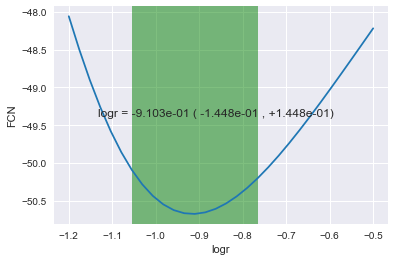

In [18]:
M_L1.draw_mnprofile('logr', bound=(-1.2, -0.5), bins=30);

In [19]:
M_L1.print_param()

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,logr,-0.915684,0.0183702,-0.0183702,0.0183702,-100.0,100.0,
2,sigma,0.0168115,0.00272844,-0.0041395,0.00697359,0.0,,


/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.013236
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.016623
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.017000
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.017376
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.017752
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.018129
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-package

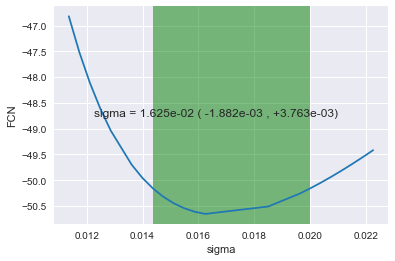

In [20]:
M_L1.draw_mnprofile('sigma');

## Scenario A

### Constant sigma

In [21]:
sigma_estimate = hepatocyte_data['d14C'].std()
sigma_estimate

0.02104804968727416

In [22]:
def neg_loglike_A(logr, sigma):
    r = np.exp(logr)
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C(Dbirth, Dcoll, r)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [23]:
M_A = iminuit.Minuit(neg_loglike_A, errordef = 0.5,\
           logr = np.log(0.0066), error_logr = np.log(1e-3), fix_logr = False,\
           sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
           print_level = 1)
M_A.migrad();

FCN = -50.67686553060637 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 2.502629089459846e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,logr,-0.9154,0.0908423,0,0,,,
2,sigma,0.016807,0.00272678,0,0,0.0,,


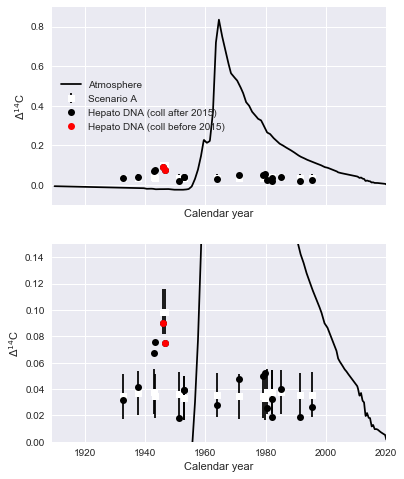

In [24]:
fig, axs = plt.subplots(2, 1, sharex = True, figsize = (6, 8))

time = sp.linspace(1910.0, 2020.0, 1000)


for ax in axs:
    ax.plot(time, K(time), label = 'Atmosphere', color = 'black')

    ax.errorbar(hepatocyte_data['Dbirth'], \
               sp.vectorize(C)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], np.exp(M_A.values['logr'])), M_A.values['sigma'],
               color = 'white', ecolor = 'black', label = 'Scenario A', marker='s', ls = '')


    ax.errorbar(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], 
            marker = 'o', ls = 'None', color = 'black',
               label = 'Hepato DNA (coll after 2015)')
    ax.errorbar(hepatocyte_data.query('Dcoll < 2015')['Dbirth'], hepatocyte_data.query('Dcoll < 2015')['d14C'], 
               marker = 'o', ls = 'None', color = 'red', 
               label = 'Hepato DNA (coll before 2015)')


    ax.set_xlim((1909, 2020))
    ax.set_ylim(-0.1, 0.9)
    ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
    # ax.grid(which='both')
    

    ax.set_xlabel('Calendar year')
    ax.set_ylabel('$\Delta^{14}$C')

axs[0].legend()
axs[1].set_ylim(-0.0, 0.15)
    
plt.savefig('c14_predict_A.svg')

plt.show()

In [25]:
M_A.minos(sigma = 1.92);

Error,-0.24044636562487737,0.33996757856452364
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.004134990706093139,0.00697816014226997
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [26]:
np.exp(CI(M_A, 'logr'))

array([ 0.31479088,  0.56246139])

In [27]:
CI(M_A, 'sigma')

(0.01267196901918199, 0.0237851198675451)

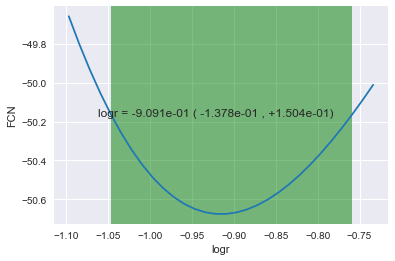

In [28]:
M_A.draw_mnprofile('logr');

/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.011353
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.012106
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.012482
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.013234
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.013610
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for sigma=0.018876
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-package

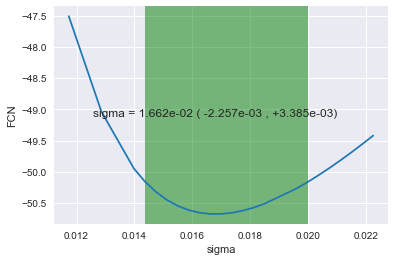

In [29]:
M_A.draw_mnprofile('sigma');

### Sigma dependent on mass of sample

In [30]:
def neg_loglike_A_mass(r, sigma_light, sigma_heavy):
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C(Dbirth, Dcoll, r)
        if dataset['mass'] < 10.0:
            sigma = sigma_light
        else:
            sigma = sigma_heavy
        
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [31]:
M_A_mass = iminuit.Minuit(neg_loglike_A_mass, errordef = 0.5,\
                          r = 0.0066, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                          sigma_light = sigma_estimate, error_sigma_light = sigma_estimate / 10.0,
                          limit_sigma_light = (0.0, None), fix_sigma_light = False,
                          sigma_heavy = sigma_estimate, error_sigma_heavy = sigma_estimate / 10.0,
                          limit_sigma_heavy = (0.0, None), fix_sigma_heavy = False,
                          print_level = 1)

In [32]:
M_A_mass.migrad();

FCN = -3.9793013675404474 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 4.375948472054117e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,0.00729104,0.409517,0,0,0.0,,
2,sigma_light,0.195992,0.0317137,0,0,0.0,,
3,sigma_heavy,0.021048,0.400745,0,0,0.0,,


## 2POP

In [33]:
def neg_loglike_2POP(r, f, sigma):
    loglike = 0
    for i, dataset in hepatocyte_data.iterrows():
        Dbirth = dataset['Dbirth']
        Dcoll = dataset['Dcoll']
        Cexp = dataset['d14C']
        Cmodel = C2(Dbirth, Dcoll, r, f)
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [34]:
M_2POP = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = 0.12, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 1)

In [35]:
M_2POP.migrad();

FCN = -50.70294794709126 
 TOTAL NCALL = 174 
 NCALLS = 174 
 
 
 EDM = 3.3956126308406938e-06 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,r,0.203528,0.00290961,0,0,0.0,,
2,f,0.995058,0.0182896,0,0,0.0,1.0,
3,sigma,0.0167815,0.0027222,0,0,0.0,,


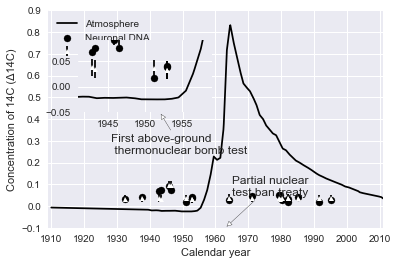

In [36]:
f, ax = plt.subplots(1, 1, figsize = (6, 4))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
ax.errorbar(hepatocyte_data['Dbirth'], \
           sp.vectorize(C2)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
            M_2POP.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.arange(1910, 2011, 10))
ax.set_xticks(sp.arange(1910, 2011, 2), minor = True)
ax.set_yticks(sp.arange(-0.1, 0.91, 0.1))
ax.set_yticks(sp.arange(-0.1, 0.91, 0.02), minor = True)
# ax.grid(which='both')
ax.legend(loc='best', numpoints = 1, scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel(u'Concentration of 14C (Δ14C)')

ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, ax.get_ylim()[0]), xytext = (1965, 0.05),
            arrowprops = dict(arrowstyle = '-|>', facecolor = 'white'))

axins = inset_axes(ax,
                   width="40%",  # width = 30% of parent_bbox
                   height=1.,  # height : 1 inch
                   loc=2, borderpad = 3)

axins.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
axins.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA            ')
axins.errorbar(hepatocyte_data['Dbirth'], \
           sp.vectorize(C2)(hepatocyte_data['Dbirth'], hepatocyte_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
            M_2POP.values['sigma'],
           color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

axins.set_xlim(1941, 1959)
axins.set_ylim(-0.05, 0.09)
axins.set_xticks(sp.arange(1945, 1956, 5))
axins.set_xticks(sp.arange(1942, 1959, 1), minor=True)

axins.annotate("First above-ground\n thermonuclear bomb test", xy = (1952, axins.get_ylim()[0]), xytext = (1945.5, axins.get_ylim()[0] - 0.08),
            arrowprops = dict(arrowstyle = '-|>', facecolor = 'white'), horizontalalignment = 'left')

exportname = 'c14_predict_2POP'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))

plt.show()

In [37]:
matplotlib.text.Text?

In [38]:
M_2POP.minos(sigma = 1.92);

Error,-0.0029096056192127184,0.0029096056192127184
Valid,False,False
At Limit,False,False
Max FCN,False,False
New Min,False,False


Error,-0.041267453714043674,0.004942427301956487
Valid,True,True
At Limit,False,True
Max FCN,False,False
New Min,False,False


/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        r = nan
        f = +0.995049
    sigma = +0.024077

  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        r = nan
        f = nan
    sigma = +0.024077

  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        r = nan
        f = +0.995049
    sigma = +0.023760

  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: fcn returns Nan
fcn is called with following arguments:
        r = nan
        f = nan
    sigma = +0.023760

  if __name__ == '__main__':


Error,-0.004126907055937736,0.006970957832365328
Valid,True,True
At Limit,False,False
Max FCN,False,False
New Min,False,False


In [39]:
CI(M_2POP, 'f')

(0.9537901189839998, 1.0)

Calculate how much bigger Spalding's CI was:

In [40]:
Delta_Rost = CI(M_2POP, 'f')[1] - CI(M_2POP, 'f')[0]
Delta_Spalding = 0.63 - 0.12
Delta_Spalding/Delta_Rost

11.036600588160184

In [41]:
CI(M_2POP, 'sigma')

(0.012654613249830002, 0.023752478138133068)

/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for f=0.986228
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for f=1.013978
  if __name__ == '__main__':
/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Migrad fails to converge for f=1.016501
  if __name__ == '__main__':


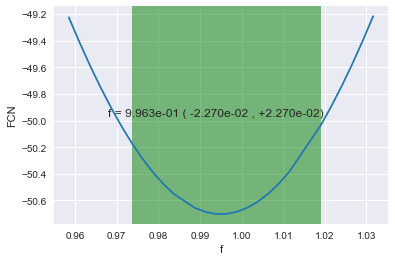

In [42]:
M_2POP.draw_mnprofile('f');

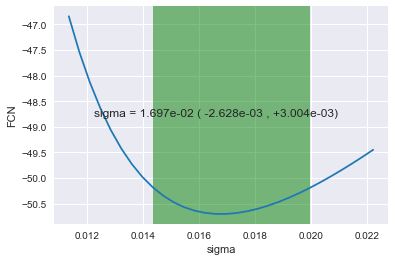

In [43]:
M_2POP.draw_mnprofile('sigma');

Manual profile likelihood for $r$ as `minos` didn't work.

In [44]:
%%cache rprofile.pkl rs neglogL
rs = sp.sort(sp.hstack((sp.linspace(0.1, 10, 50), M_2POP.values['r'], 0.15)))
f_initial = M_2POP.values['f']
sigma_initial = M_2POP.values['sigma']
def fit_fix_r(r):
    M_2POP = iminuit.Minuit(neg_loglike_2POP, errordef = 0.5,\
                   r = r, error_r = 1e-3, limit_r = (0.0, None), fix_r = True,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = sigma_estimate, error_sigma = sigma_estimate / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP.migrad()
    if M_2POP.migrad_ok():
        return M_2POP.fval
    else:
        return sp.nan

pool = Pool(processes=4) 

neglogL = sp.array(pool.map(fit_fix_r, rs))

UsageError: Cell magic `%%cache` not found.


In [ ]:
func = sp.interpolate.interp1d(rs, neglogL - neglogL.min() - 1.92) 

In [ ]:
from scipy import optimize
rmin = sp.optimize.root(func, 0.1, method='lm')['x'].item()
rmax = sp.optimize.root(func, 2, method='lm')['x'].item()

print('r:')
print('{0:.2f} (95\% CI [{1:.2f}, {2:.2f}])'.format(M_2POP.values['r'], rmin, rmax))


In [ ]:
fig = plt.figure(figsize= (150 / 25.4, 50 / 25.4) )
plt.xlim(0, 10)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

plt.plot(rs, -(neglogL-M_2POP.fval), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

exportname = 'rprofile'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))

plt.show()

## 2POP mass

In [ ]:
def neg_loglike_2POP_mass(r, f, sigma_light, sigma_heavy):
    loglike = 0
    for i, row in hepatocyte_data.iterrows():
        Dbirth = row['Dbirth']
        Dcoll = row['Dcoll']
        Cexp = row['d14C']
        Cmodel = C2(Dbirth, Dcoll, r, f)
        if row['mass'] < 10.0:
            sigma = sigma_light
        else:
            sigma = sigma_heavy
        
        loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
    return -loglike

In [ ]:
M_2POP_mass = iminuit.Minuit(neg_loglike_2POP_mass, errordef = 0.5,\
                   r = 0.12, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f=0.35, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma_light = sigma_estimate*20, error_sigma_light = sigma_estimate / 10.0, limit_sigma_light = (0.0, None), fix_sigma_light = False,
                   sigma_heavy = sigma_estimate, error_sigma_heavy = sigma_estimate / 10.0, limit_sigma_heavy = (0.0, None), fix_sigma_heavy = False,\
                   print_level = 1)

In [ ]:
M_2POP_mass.migrad();

## Sample size estimation
Here, I create simulated data from the model to estimate the sample size (needed number of additional subjects) to find a upper limit for $r$. In the model simulation I'll use the estimated point estimates of the parameters as true parameters. I use scenario 2POP.
### Simulate the model

In [ ]:
f_fit = M_2POP.values['f']
r_fit = M_2POP.values['r']
sigma_fit = M_2POP.values['sigma']

Let's first plot the model prediction for the expected difference in C-14 concentration when comparing the cases $r = r_{estimate}$ and $r = r_{max}$ and different birth and death times:

In [ ]:
time_min, time_max = 1910, 2015
sampling = 1
birth_times, death_times = sp.mgrid[time_min:time_max:sampling, time_min:time_max:sampling]
C14_diff = sp.absolute(sp.vectorize(C2)(birth_times, death_times, r_fit, f_fit) - sp.vectorize(C2)(birth_times, death_times, rmax, f_fit))
C14_diff = sp.ma.masked_array(C14_diff, mask = sp.isnan(C14_diff))

In [ ]:
%config InlineBackend.figure_format = 'png'
fig, ax = plt.subplots(figsize = (3,2))
pcm = ax.pcolormesh(birth_times, death_times, C14_diff, cmap = 'viridis')
ax.set_xlabel('year of birth')
ax.set_ylabel('year of death', labelpad=10)
fig.colorbar(pcm)
ax.set_xlim(time_min, time_max)
ax.set_ylim(time_min, time_max)
ax.set_xticks(sp.arange(time_min, time_max, 20))
ax.set_xticks(sp.arange(time_min+10, time_max, 20), minor = True)
ax.set_yticks(sp.arange(time_min, time_max, 20))
ax.set_yticks(sp.arange(time_min+10, time_max, 20), minor = True)
# plt.contour(birth_times, death_times, C14_diff, [0.05], colors = 'red')

plt.show()

In [ ]:
max_index = sp.unravel_index(C14_diff.argmax(), C14_diff.shape)
death_times[max_index]

The biggest difference in C-14 is expected for subjects that died in 1965. 

### Creation of artifical subject data

#### Informative data

Based on the assumption that I my parameters are the true parameters I create artifical subject data by simulating the model. I'll choose subjects for which the expected difference in C-14 for the cases $r = r_{estimate}$ and $r = r_{max}$ is bigger than $0.05$.

In [ ]:
fig, ax = plt.subplots(figsize = (3,2))
pcm = ax.pcolormesh(birth_times, death_times, C14_diff > 0.05, cmap = 'Greys')
ax.set_xlabel('year of birth')
ax.set_ylabel('year of death')
fig.colorbar(pcm)
ax.set_xlim(time_min, time_max)
ax.set_ylim(time_min, time_max)

plt.show()

In [ ]:
chosen_birth_times = birth_times[C14_diff > 0.05]
chosen_death_times = death_times[C14_diff > 0.05]
chosen_times = zip(chosen_birth_times, chosen_death_times)

In [ ]:
%%cache profiles_r_2POP.pkl profile_r_2POP
profile_r_2POP = M_2POP.mnprofile('r', bound = [0.1, 1.5], subtract_min = True, bins = 60)

In [ ]:
%%cache profiles.pkl profiles test_datasets
n = 5
test_datasets = {}
profiles = {}
for i in range(5):
    sp.random.seed(i)
    
    indices = sp.random.choice(len(chosen_birth_times), n)
    
#     sampled_birth_times = chosen_birth_times[indices]
#     sampled_death_times = chosen_death_times[indices]

    sampled_birth_times = sp.random.uniform(1910, 1960, n)
    sampled_death_times = sp.random.uniform(1961, 1970, n)
    d14C = sp.vectorize(C2)(sampled_birth_times, sampled_death_times, r_fit, f_fit) + sp.random.normal(0, sigma_fit, len(sampled_birth_times))
    
    new_data = pd.DataFrame.from_dict({'Dbirth': sampled_birth_times, 'Dcoll': sampled_death_times, 'd14C': d14C})
    
    test_datasets[i] = pd.concat([hepatocyte_data, new_data], ignore_index=True)

for i, data in test_datasets.iteritems():
    def neg_loglike_2POP_test(r, f, sigma):
        loglike = 0
        for i, dataset in data.iterrows():
            Dbirth = dataset['Dbirth']
            Dcoll = dataset['Dcoll']
            Cexp = dataset['d14C']
            Cmodel = C2(Dbirth, Dcoll, r, f)

            loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
        return -loglike

    M_2POP_test = iminuit.Minuit(neg_loglike_2POP_test, errordef = 0.5,\
                   r = 0.2, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f= 0.3, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = 0.01, error_sigma = sigma_fit / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP_test.tol = 10.0
    M_2POP_test.migrad()
#     M_2POP_test.minos('r', sigma = 1.92)
    if M_2POP_test.migrad_ok():
        profiles[i] = M_2POP_test.mnprofile('r', bound = [0.1, 0.5], subtract_min = True, bins = 25);

Plot the artificial test data

In [ ]:
i = 1
artificial_data = test_datasets[i]

f, ax = plt.subplots(1, 1, figsize = (3, 2))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(artificial_data['Dbirth'], artificial_data['d14C'], color = colorcycle[i+1], label = 'Artificial data            ')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA                   ')
# ax.errorbar(artificial_data['Dbirth'], \
#            sp.vectorize(C2)(artificial_data['Dbirth'], artificial_data['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
#             M_2POP.values['sigma'],
#            color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')
ax.legend(loc='best', scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

# ax.annotate("First above-ground\nnuclear bomb test", xy = (1955, K(1955)), xytext = (1965, -0.08),
#             arrowprops = dict(arrowstyle = '-|>'))
# ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, K(1963)), xytext = (1967, 0.05),
#             arrowprops = dict(arrowstyle = '-|>'))


plt.show()

In [ ]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize= (75 / 25.4, 50 / 25.4) )
plt.xlim(0.1, 0.4)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

plt.plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

for i, profile in profiles.iteritems():
    plt.plot(profile[0], -sp.array(profile[1]), color = colorcycle[i+1])


plt.show()

#### 'Recent' data
Now, I repeat the creation of artificial data as above, but for patients that died in recent years. I choose 2012. I assume they are born bewteen 1910 and 2010 with uniform random distribution.

In [ ]:
len(hepatocyte_data)

In [ ]:
%%cache profiles_recent.pkl profiles_recent test_datasets_recent
n = 100
test_datasets_recent = {}
profiles_recent = {}
for i in sp.arange(5)+1:
    sp.random.seed(i)
    
    sampled_birth_times = sp.random.uniform(1910, 2010, n)
    sampled_death_times = 2012 * sp.ones(n)
    d14C = sp.vectorize(C2)(sampled_birth_times, sampled_death_times, r_fit, f_fit) + sp.random.normal(0, sigma_fit, len(sampled_birth_times))
    
    new_data = pd.DataFrame.from_dict({'Dbirth': sampled_birth_times, 'Dcoll': sampled_death_times, 'd14C': d14C})
    
    test_datasets_recent[i] = pd.concat([hepatocyte_data, new_data], ignore_index=True)

for i, data in test_datasets_recent.iteritems():
    def neg_loglike_2POP_test(r, f, sigma):
        loglike = 0
        for i, dataset in data.iterrows():
            Dbirth = dataset['Dbirth']
            Dcoll = dataset['Dcoll']
            Cexp = dataset['d14C']
            Cmodel = C2(Dbirth, Dcoll, r, f)

            loglike += sp.stats.norm.logpdf(Cexp, loc=Cmodel, scale=sigma)
        return -loglike

    M_2POP_test = iminuit.Minuit(neg_loglike_2POP_test, errordef = 0.5,\
                   r = 0.2, error_r = 1e-3, limit_r = (0.0, None), fix_r = False,\
                   f= 0.3, error_f=0.01, limit_f=(0.0, 1.0), fix_f = False,\
                   sigma = 0.01, error_sigma = sigma_fit / 10.0, limit_sigma = (0.0, None), fix_sigma = False,\
                   print_level = 0)
    M_2POP_test.tol = 10.0
    M_2POP_test.migrad()
#     M_2POP_test.minos('r', sigma = 1.92)
    if M_2POP_test.migrad_ok():
        profiles_recent[i] = M_2POP_test.mnprofile('r', bound = [0.1, 1.5], subtract_min = True, bins = 60);

Plot the artificial test data

In [ ]:
i = 1
artificial_data_recent = test_datasets_recent[i]

f, ax = plt.subplots(1, 1, figsize = (3, 2))

time = sp.linspace(1910.0, 2015.0, 1000)
ax.plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax.scatter(artificial_data_recent['Dbirth'], artificial_data_recent['d14C'], color = colorcycle[7], label = 'Artificial data            ')
ax.scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], color = 'black', label = 'Neuronal DNA                   ')
# ax.errorbar(artificial_data_recent['Dbirth'], \
#            sp.vectorize(C2)(artificial_data_recent['Dbirth'], artificial_data_recent['Dcoll'], M_2POP.values['r'], M_2POP.values['f']),\
#             M_2POP.values['sigma'],
#            color = 'white', ecolor = 'black', label = '2POP', marker='^', ls = '', ms = 5)

ax.set_xlim((1909, 2011))
ax.set_ylim(-0.1, 0.9)
ax.set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
# ax.grid(which='both')
ax.legend(loc='best', scatterpoints = 1)

ax.set_xlabel('Calendar year')
ax.set_ylabel('$\Delta^{14}$C')

# ax.annotate("First above-ground\nnuclear bomb test", xy = (1955, K(1955)), xytext = (1965, -0.08),
#             arrowprops = dict(arrowstyle = '-|>'))
# ax.annotate("Partial nuclear\ntest ban treaty", xy = (1963, K(1963)), xytext = (1967, 0.05),
#             arrowprops = dict(arrowstyle = '-|>'))

plt.show()

In [ ]:
%config InlineBackend.figure_format = 'svg'

fig = plt.figure(figsize= (75 / 25.4, 50 / 25.4) )
plt.xlim(0.1, 1.5)
plt.ylim(-2.5, 0)

plt.xlabel('turnover rate, r (per year)')
plt.ylabel('$\Delta \ln L$')

# plt.grid()

# plt.plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
plt.plot(rs, -(neglogL-M_2POP.fval), 'black')
plt.plot([0, 10], [-1.92, -1.92], 'k--')
# plt.plot([rmin, rmin], [-5, 0], 'k--')
# plt.plot([rmax, rmax], [-5, 0], 'k--')

for i, profile in profiles_recent.iteritems():
    plt.plot(profile[0], -sp.array(profile[1]), color = colorcycle[i+1])

plt.show()

### Plot of artifial data results for thesis

In [ ]:
lineStyles = ['-', '--', '-.', ':']

new_artifical_data = artificial_data.loc[artificial_data.index.difference(hepatocyte_data.reset_index().index)]
new_artifical_data_recent = artificial_data_recent.loc[artificial_data_recent.index.difference(hepatocyte_data.reset_index().index)]

%config InlineBackend.figure_format = 'png'
fig, ax = plt.subplots(2, 2, figsize = (160/25.4,4))

pcm = ax[0,0].pcolormesh(birth_times, death_times, C14_diff, cmap = 'viridis', shading = 'gourad')
ax[0,0].scatter(new_artifical_data_recent['Dbirth'].values, new_artifical_data_recent['Dcoll'].values,
                marker = '+', c = colorcycle[1])
ax[0,0].scatter(new_artifical_data['Dbirth'].values, new_artifical_data['Dcoll'].values,
                marker = '+', c = colorcycle[7])
ax[0,0].scatter(hepatocyte_data['Dbirth'].values, hepatocyte_data['Dcoll'].values, marker = '+', c = 'white')
ax[0,0].set_xlabel('Year of birth')
ax[0,0].set_ylabel('Year of death', labelpad=10)
cb = fig.colorbar(pcm, ax=ax[0,0])
cb.set_label(u'Difference in Δ14C', labelpad = 10)
ax[0,0].set_xlim(time_min, time_max)
ax[0,0].set_ylim(time_min, time_max)
ax[0,0].set_xticks(sp.arange(time_min, time_max, 20))
ax[0,0].set_xticks(sp.arange(time_min+10, time_max, 20), minor = True)
ax[0,0].set_yticks(sp.arange(time_min, time_max, 20))
ax[0,0].set_yticks(sp.arange(time_min+10, time_max, 20), minor = True)
# ax[0,0].add_patch(patches.Rectangle((1910, 2012), 100, 1, fill=False, color=colorcycle[1]))
# ax[0,0].add_patch(patches.Rectangle((1910, 1961), 50, 9, fill=False, color=colorcycle[2]))


artificial_data = test_datasets[1]
msize = 5
time = sp.linspace(1910.0, 2015.0, 1000)
ax[0,1].plot(time, K(time), label = 'Atmosphere                    ', color = 'black')
ax[0,1].scatter(hepatocyte_data['Dbirth'], hepatocyte_data['d14C'], 
                color = 'black', label = 'Neuronal DNA                        ', s = msize)
ax[0,1].scatter(new_artifical_data_recent['Dbirth'], new_artifical_data_recent['d14C'], 
                color = colorcycle[1], label = 'Artifical data 1', s = msize)
ax[0,1].scatter(new_artifical_data['Dbirth'], new_artifical_data['d14C'], 
                color = colorcycle[7], label = 'Artifical data 2     ', s = msize)


ax[0,1].set_xlim((1909, 2011))
ax[0,1].set_ylim(-0.1, 0.9)
ax[0,1].set_xticks(sp.linspace(1910, 2010, 6), minor = 1)
ax[0,1].legend(loc='upper left', scatterpoints = 1)
ax[0,1].set_xlabel('Calendar year')
ax[0,1].set_ylabel(u'Δ14C')

ax[1,0].set_title('Artificial data 1', fontsize = 8)
ax[1,0].set_xlim(0.1, 1.5)
ax[1,0].set_ylim(-2.5, 0)
ax[1,0].set_xlabel('Turnover rate, r (per year)')
ax[1,0].set_ylabel(u'Δln L')
ax[1,0].plot(profile_r_2POP[0], -sp.array(profile_r_2POP[-1]), 'black')
# ax[1,0].plot(rs, -(neglogL-M_2POP.fval), 'black')
ax[1,0].plot([0, 10], [-1.92, -1.92], 'k--')
for i, profile in profiles_recent.iteritems():
    ax[1,0].plot(profile[0], -sp.array(profile[1]), color = colorcycle[1], ls = lineStyles[len(profile) - i])
    if i == len(lineStyles):
        break
    
ax[1,1].set_title('Artificial data 2', fontsize = 8)
ax[1,1].set_xlim(0.1, 1.5)
ax[1,1].set_ylim(-2.5, 0)
ax[1,1].set_xlabel('Turnover rate, r (per year)')
ax[1,1].set_ylabel(u'Δln L')
ax[1,1].plot(profile_r_2POP[0], -sp.array(profile_r_2POP[1]), 'black')
# ax[1,1].plot(rs, -(neglogL-M_2POP.fval), 'black')
ax[1,1].plot([0, 10], [-1.92, -1.92], 'k--')
for i, profile in profiles.iteritems():
    ax[1,1].plot(profile[0], -sp.array(profile[1]), color = colorcycle[7], ls = lineStyles[i-1])
    if i == len(lineStyles):
        break

plt.tight_layout()

exportname = 'c14_add_data'
plt.savefig('{}.svg'.format(exportname))
os.system('inkscape -D -z --file={0}.svg --export-pdf={0}.pdf'.format(exportname))


plt.show()